In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Google_Stock_Price_Train.csv to Google_Stock_Price_Train.csv


In [29]:
df = pd.read_csv('Google_Stock_Price_Train.csv')

In [30]:
df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [31]:
df.shape

(1258, 6)

In [32]:
# Splitting into 80% training and 20% testing
training_set = df.iloc[:1007, 1:2].values
test_set = df.iloc[1007:, 1:2].values

In [7]:
# training_set = df.iloc[:, 1: 2].values

In [33]:
training_set[1:3]

array([[331.27],
       [329.83]])

In [34]:
sc = MinMaxScaler(feature_range = (0, 1))

In [35]:
training_set_scaled = sc.fit_transform(training_set)

In [36]:
# X train will have data of 60 days prior to the date and y train will have data of one day after the date

In [37]:
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60: i, 0])
    y_train.append(training_set_scaled[i, 0])

In [38]:
np.shape(X_train)

(947, 60)

In [39]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [40]:
X_train = np.reshape(X_train, newshape = 
                     (X_train.shape[0], X_train.shape[1], 1))

In [41]:
X_train.shape

(947, 60, 1)

In [42]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [43]:
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
30/30 [==============================] - 7s 16ms/step - loss: 0.0287
Epoch 2/100
30/30 [==============================] - 0s 15ms/step - loss: 0.0061
Epoch 3/100
30/30 [==============================] - 0s 15ms/step - loss: 0.0062
Epoch 4/100
30/30 [==============================] - 0s 15ms/step - loss: 0.0059
Epoch 5/100
30/30 [==============================] - 0s 15ms/step - loss: 0.0063
Epoch 6/100
30/30 [==============================] - 0s 15ms/step - loss: 0.0053
Epoch 7/100
30/30 [==============================] - 0s 15ms/step - loss: 0.0048
Epoch 8/100
30/30 [==============================] - 0s 14ms/step - loss: 0.0047
Epoch 9/100
30/30 [==============================] - 0s 15ms/step - loss: 0.0048
Epoch 10/100
30/30 [==============================] - 0s 15ms/step - loss: 0.0044
Epoch 11/100
30/30 [==============================] - 0s 15ms/step - loss: 0.0037
Epoch 12/100
30/30 [==============================] - 0s 15ms/step - loss: 0.0035
Epoch 13/100
30/30 [=====

In [44]:
dataset_train = df.iloc[:1007, 1:2]
dataset_test = df.iloc[1007:, 1:2]

In [45]:
dataset_test.head()

,Open
1007,746.45
1008,730.00
1009,730.31
1010,731.45
1011,716.61


In [46]:
real_stock_price = dataset_test.iloc[:, 1: 2].values

In [47]:
real_stock_price.shape

(251, 0)

In [48]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), 
                          axis = 0)
dataset_total.head()


0    325.25
1    331.27
2    329.83
3    328.34
4    322.04
Name: Open, dtype: float64

In [49]:
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
print(inputs.shape)

(311,)


In [50]:

#reshape data to only have 1 col
inputs = inputs.reshape(-1, 1)

#scale input
inputs = sc.transform(inputs)
print(inputs.shape)

(311, 1)


In [51]:
# test data
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
#add dimension of indicator
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [52]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

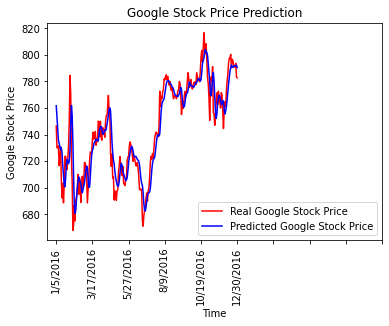

In [53]:
# Visualizing results
plt.plot(df.loc[1007:, 'Date'],dataset_test.values, color = 'red', label = 'Real Google Stock Price')
plt.plot(df.loc[1007:, 'Date'],predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.xticks(np.arange(0,459,50))
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
# Observations
# Loss decreased from 0.0287 to 0.0013 by end of 100 epochs
# previous 60 days’ stock prices are used to predict the next-day price
# Model lags behind the real values, because the model cannot react fast to non-linear changes. 
# Model reacts well to smooth changes. So, we can conclude thatbin the parts of prediction which contain spikes, the model lags behind the actual prices, 
# but in the parts that contain smooth changes, the model manages to follow upwards and downward trends